# Table Of Contents:

### 1. [Data Load](#1)
### 2. [Train/Test Split](#2)
### 3. [Modeling - ARIMA](#3)
>a. [ARIMA Results](#3.a)
### 4. [Modeling - Facebook Prophet](#4)
>a. [Prophet Results](#4.a)
### 5. [Comparative Analysis](#5)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

## Data Load <a class="anchor" id="data-load"></a>

In [2]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*7)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

stock= 'SPLV'

df = yf.download(stock, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
df["Date"] = df.index
df = df[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1754,2024-07-19,67.260002,67.410004,66.589996,66.660004,66.558006,1688100
1755,2024-07-22,66.720001,67.000000,66.540001,66.980003,66.980003,884000
1756,2024-07-23,66.980003,67.040001,66.599998,66.639999,66.639999,1015300
1757,2024-07-24,66.500000,66.690002,66.220001,66.459999,66.459999,1103900
1758,2024-07-25,66.570000,67.320000,66.470001,66.500000,66.500000,1143100


In [3]:
df_close = df[['Date', 'Close']]
df_close.set_index("Date", inplace=True)
df_close.head()

,Close
Date,
2017-07-28,45.169998
2017-07-31,45.259998
2017-08-01,45.380001
2017-08-02,45.380001
2017-08-03,45.450001


## Train/Test Split <a class="anchor" id="2"></a>

Train, Test split on 80% of the data

In [4]:
train_data, test_data = df_close[3:int(len(df_close)*0.8)], df_close[int(len(df_close)*0.8):]

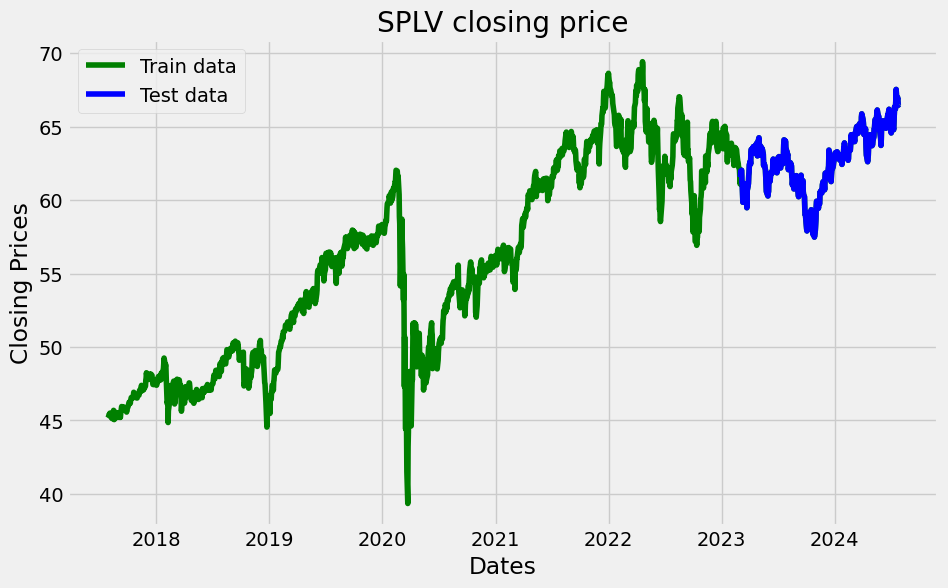

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('{} closing price'.format(stock))
plt.legend()

<Figure size 640x480 with 0 Axes>

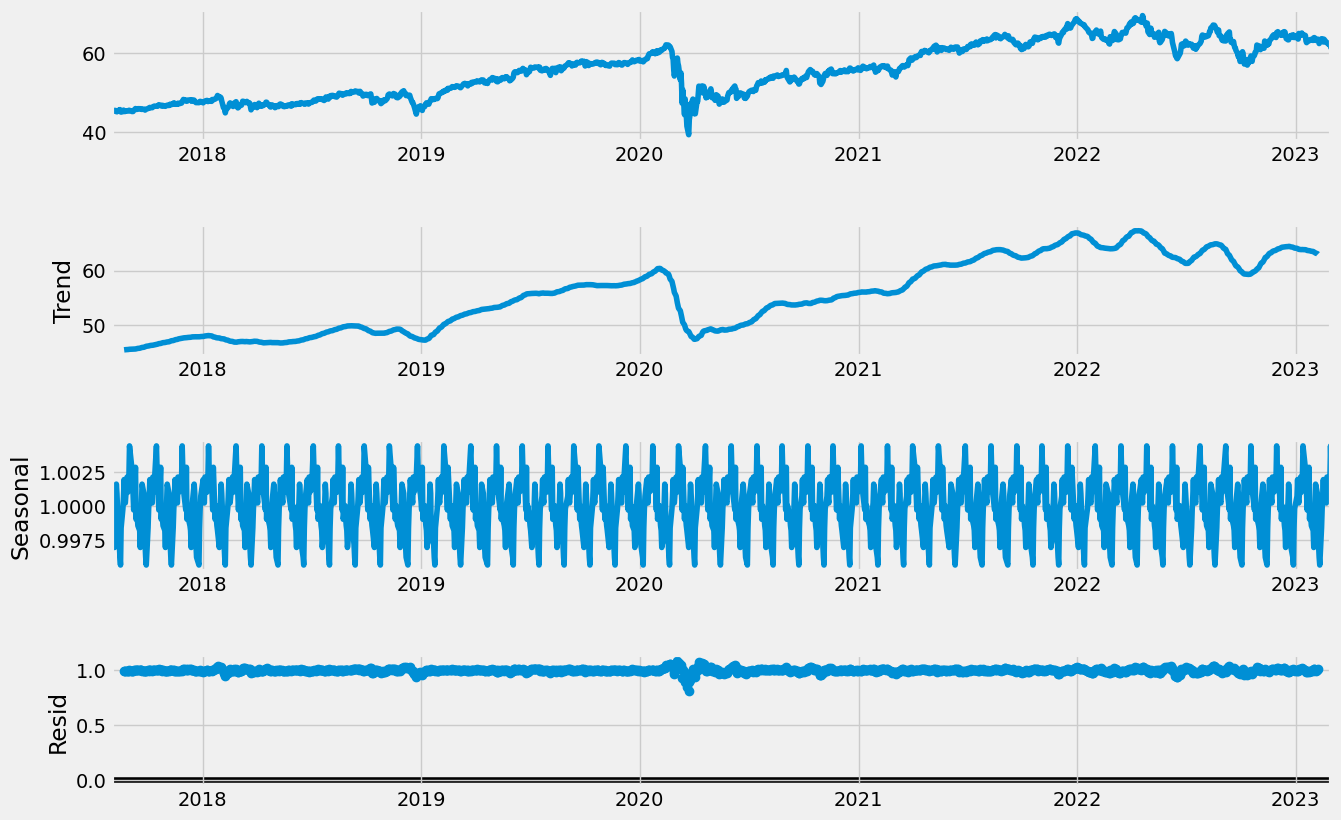

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_data, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Our data has seasonality 

Null Hypothesis (H0): The time series has is non-stationary <br>
Alternative Hypothesis (H1): The time series it is stationary

In [45]:
df_adf = adfuller(df['Close'])
print('ADF Statistic (Differenced Series):', df_adf[0])
print('p-value (Differenced Series):', df_adf[1])

ADF Statistic (Differenced Series): -1.916121722432605
p-value (Differenced Series): 0.32451536373038314


In [11]:
train_data_diff = train_data.diff().dropna()

In [12]:
train_data_adf = adfuller(train_data_diff)
print('ADF Statistic (Differenced Series):', train_data_adf[0])
print('p-value (Differenced Series):', train_data_adf[1])

ADF Statistic (Differenced Series): -11.046514803125254
p-value (Differenced Series): 5.2067285389968135e-20


After applying differencing, our new p-value is smaller than 0.05. Therefore we reject the null hypothesis, this mean our series is stationary

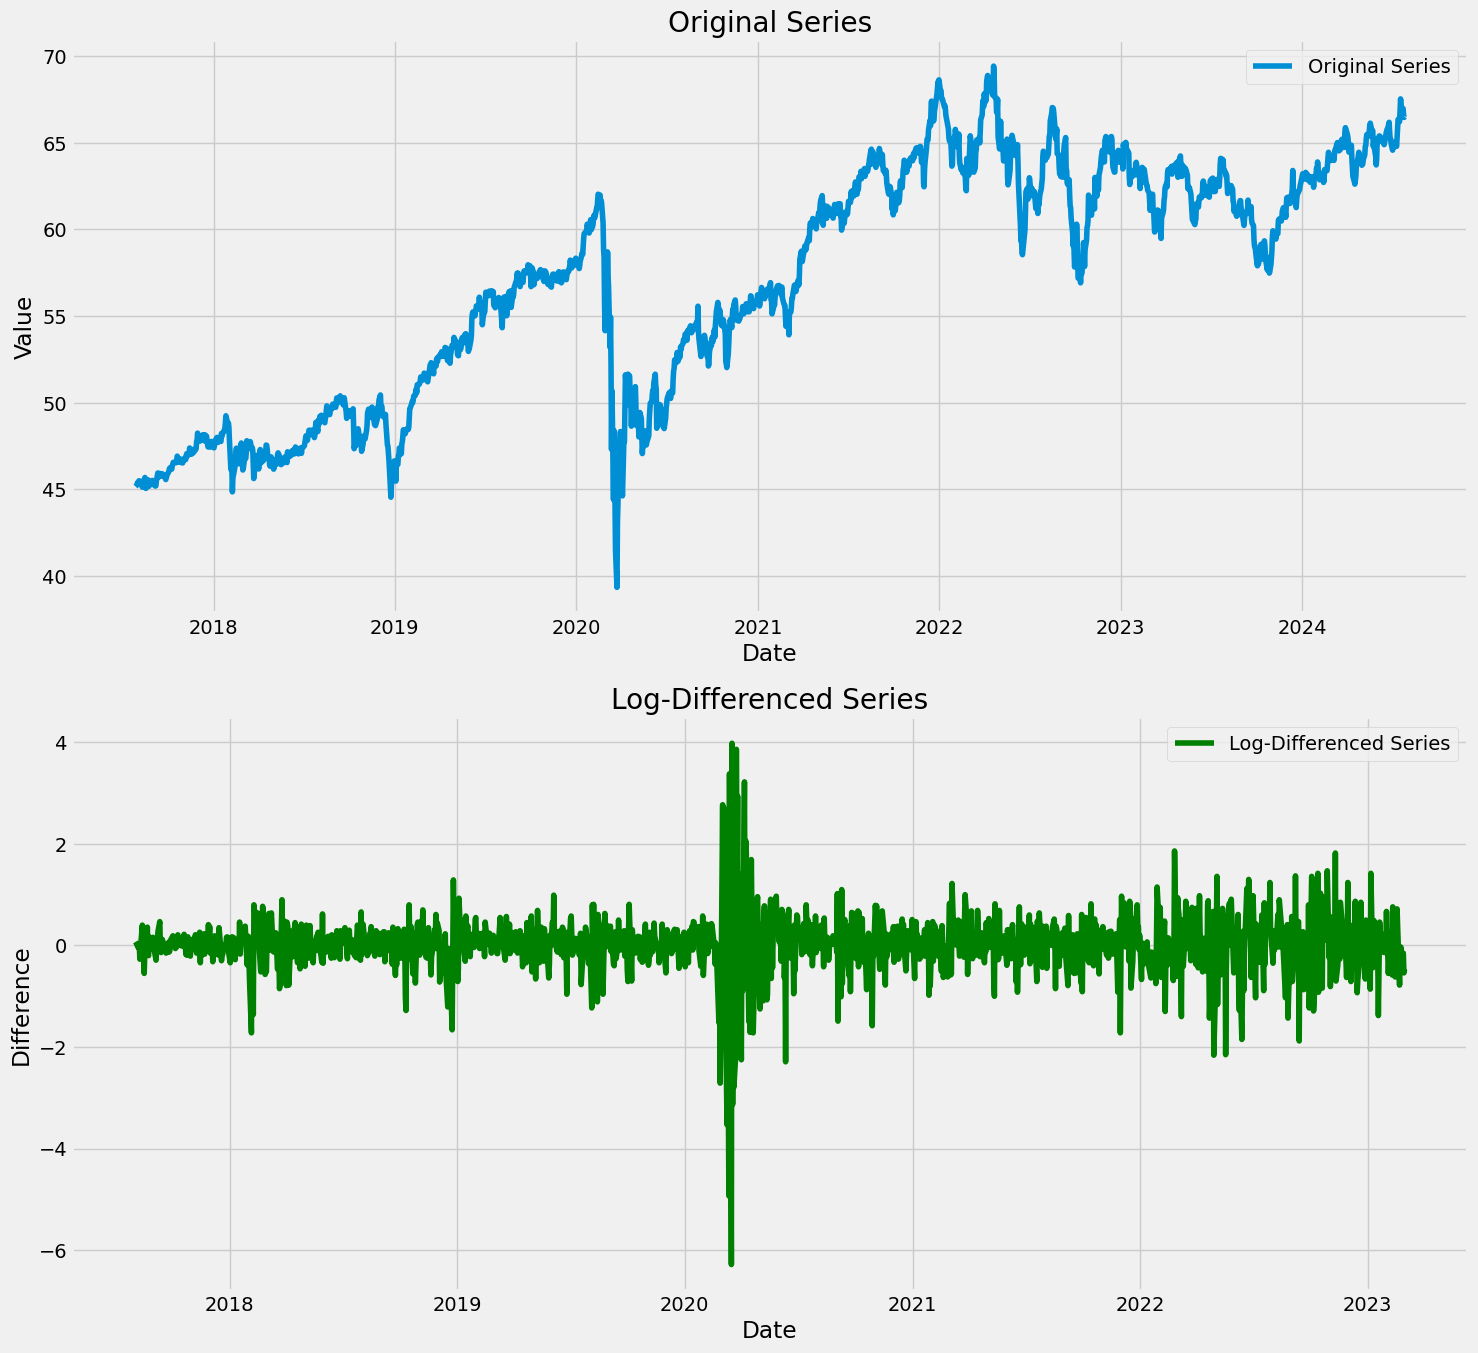

In [13]:
# Plotting
plt.figure(figsize=(15, 20))

# Original Series
plt.subplot(311)
plt.plot(df_close, label='Original Series')
plt.title('Original Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Differenced Series
plt.subplot(312)
plt.plot(train_data_diff, label='Log-Differenced Series', color='green')
plt.title('Log-Differenced Series')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()

plt.tight_layout()
plt.show()

# Modeling - ARIMA <a class="anchor" id="3"></a>

### Auto_Arima helps us identify the best p,d,q

In [14]:
from pmdarima import auto_arima
model = auto_arima(train_data_diff, 
                   seasonal=False,  # Change to True if you have seasonal data
                   trace=True,
                   m=24,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True,)

p = model.order[0]
d = model.order[1]
q = model.order[2]

C:\Users\imdan\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2539.156, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2594.255, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2564.065, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2570.299, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2545.529, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2550.528, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2463.076, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2473.199, Time=0.28 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2542.983, Time=0.63 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2463.035, Time=0.60 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2542.865, Time=0.19 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=2464.886, Time=0.65 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2474.964, Time=0.38 sec
 ARIMA(3,0,4)(0,0,0)[0]             : 

### Fitting the model

In [15]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_diff,
                order=(p, d, q) 
             )
fitted = model.fit() 
print(fitted.summary())

C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1403
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1225.257
Date:                Fri, 26 Jul 2024   AIC                           2464.515
Time:                        21:37:02   BIC                           2501.239
Sample:                             0   HQIC                          2478.242
                               - 1403                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.017      0.665      0.506      -0.022       0.044
ar.L1         -1.5749      0.029    -53.833      0.000      -1.632      -1.518
ar.L2         -0.6992      0.027    -25.874      0.0

C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast to predict the trend

In [16]:
forecast_steps = len(test_data)  # Number of periods to forecast
result = fitted.forecast(forecast_steps, alpha = 0.05)
conf_ins = fitted.get_forecast(forecast_steps).summary_frame()


C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [17]:
#undo differencing
def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value,series_diff].cumsum().astype('float64')
    return series_inverted

#take the initial value of test_data_log
test_data_log = np.log(test_data)

inversed_result = diff_inv(result , test_data['Close'][0])
inversed_result = pd.Series(inversed_result)
inversed_result = inversed_result[:len(test_data)]
inversed_result.index = test_data.index

result = inversed_result
#Undo logs
#result = np.exp(inversed_result)


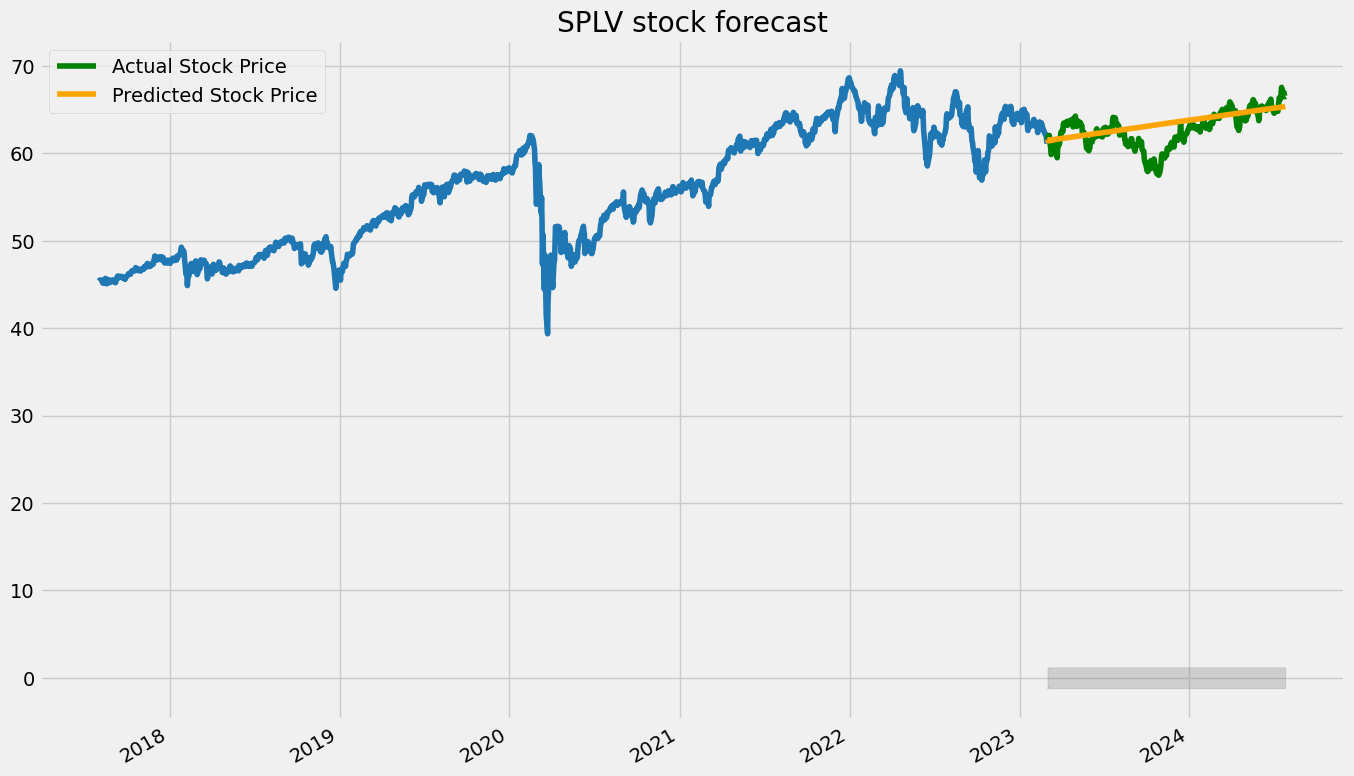

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))


ax.plot(train_data.index, train_data.values, color = '#1f77b4')
ax.plot(test_data.index, test_data.values, label='Actual Stock Price',color = 'green')
ax.plot(test_data.index, result, label='Predicted Stock Price', color = 'orange')
ax.fill_between(test_data.index,conf_ins['mean_ci_lower'],conf_ins['mean_ci_upper'],color='grey', alpha=0.3)
plt.title('{} stock forecast'.format(stock))
ax.legend()
fig.autofmt_xdate()
plt.show()

### Future predictions

In [19]:
future_forecast_steps = 600  # Number of periods to forecast
future_result = fitted.forecast(future_forecast_steps, alpha = 0.05)
future_conf_ins = fitted.get_forecast(future_forecast_steps).summary_frame()

C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [20]:
future_dates = pd.date_range(start=test_data.index[0] + pd.Timedelta(days=1), periods=future_forecast_steps, freq='B')
future_dates = pd.DataFrame(index=future_dates, columns=df.columns)

In [21]:
future_inversed_series = diff_inv(future_result , test_data['Close'][0])
future_inversed_series = pd.Series(future_inversed_series)
future_inversed_series = future_inversed_series[:len(future_result)]
future_inversed_series.index = future_dates.index
future_result = future_inversed_series

#Undo logs
#future_result = np.exp(future_inversed_series)

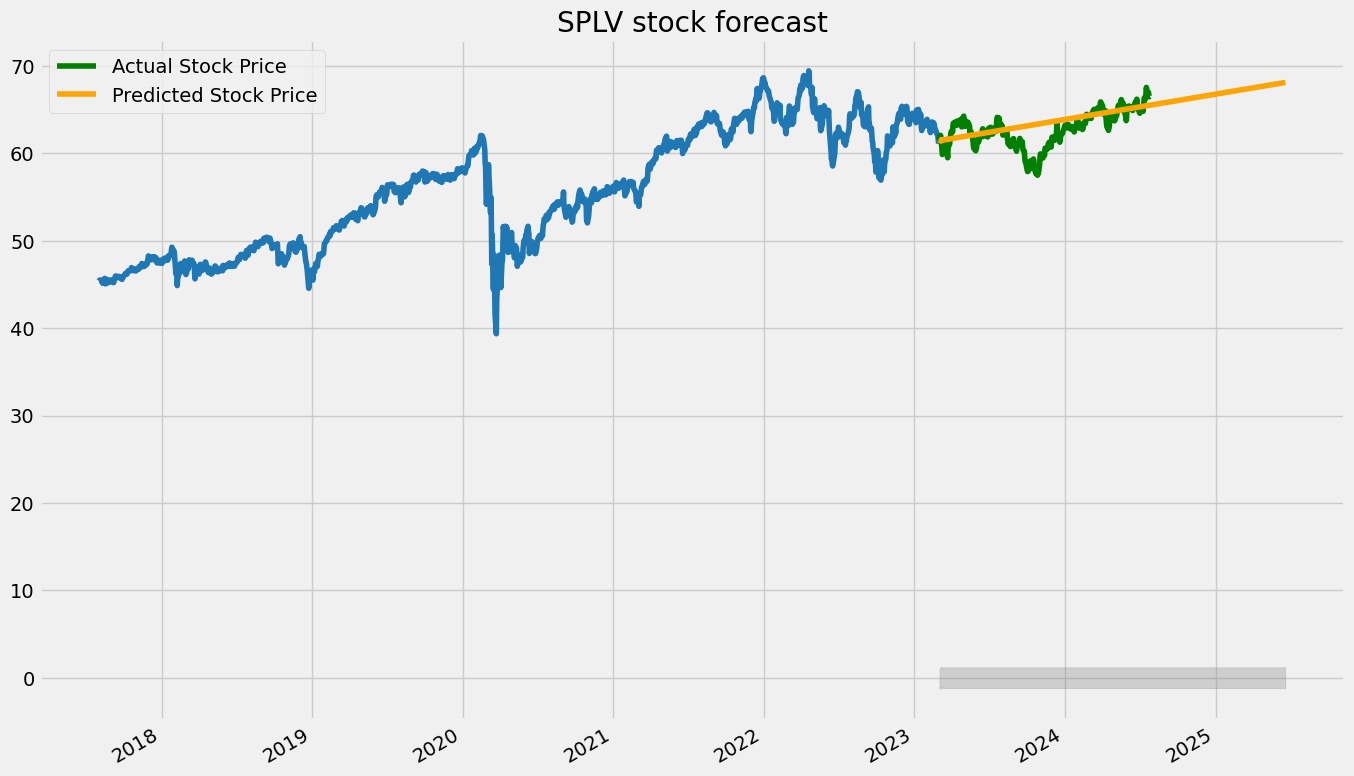

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))


ax.plot(train_data.index, train_data.values, color = '#1f77b4')
ax.plot(test_data.index, test_data.values, label='Actual Stock Price',color = 'green')
ax.plot(future_dates.index, future_result, label='Predicted Stock Price', color = 'orange')
ax.fill_between(future_dates.index,future_conf_ins['mean_ci_lower'],future_conf_ins['mean_ci_upper'],color='grey', alpha=0.3)
plt.title('{} stock forecast'.format(stock))
ax.legend()
fig.autofmt_xdate()
plt.show()

In [23]:
specific_date_value = future_result['2025-01-01']
print(f"Forecasted value for 2025-01-01: {specific_date_value}")

Forecasted value for 2025-01-01: 66.75408622847003


## ARIMA Results <a class="anchor" id="3.a"></a>

## Metrics

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, result)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, result)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, result))
print('RMSE: '+str(rmse))

test_series = (test_data['Close'].values)
test=result-test_series
test_data_abs = np.abs(test_data).values

mape = np.mean(np.abs(test).values)/test_data_abs
mape = np.mean(mape)
print('MAPE: '+str(mape))

ARIMA_results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Value': [mse, mae, rmse, mape]
})

MSE: 3.3500720984115304
MAE: 1.3364723355600459
RMSE: 1.830320217451452
MAPE: 0.021343545247360842


In [25]:
ARIMA_results

,Metric,Value
0,MSE,3.350072
1,MAE,1.336472
2,RMSE,1.830320
3,MAPE,0.021344


MAPE (Mean Absolute Percentage Error): This measures the average absolute percentage difference between the actual and predicted stock prices. It gives an idea of the error relative to the size of the stock prices. And given that our model's MAPE is 2.1% difference between Actual and Prediction is pretty impressive.

The error metrics (MSE, MAE, RMSE, MAPE) are relatively low, indicating that the model's predictions are reasonably accurate, though not perfect.

Overall, the graph and metrics together provide a comprehensive view of how well the forecasting model performs and its expected accuracy in predicting future stock prices.

# Modeling - Facebook Prophet <a class="anchor" id="4"></a>

Prophet only takes [ds] and [y], so we need to rename our train_data columns

In [26]:
train_data = train_data.reset_index()
train_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [27]:
train_data.head()

,ds,y
0,2017-08-02,45.380001
1,2017-08-03,45.450001
2,2017-08-04,45.500000
3,2017-08-07,45.470001
4,2017-08-08,45.419998


Define functions for model testing and model evaluation

In [28]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np

def train_prophet_model(train_data, changepoint_prior_scale=0.05, seasonality_prior_scale=10, holidays_prior_scale=10,
                        seasonality_mode='additive'):
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model.fit(train_data)
    return model

def evaluate_model(train_df, model):
    df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='30 days')
    df_p = performance_metrics(df_cv)
    return df_p

Finding the best parameters

In [29]:
from itertools import product

changepoint_prior_scales = [0.01, 0.05, 0.1]
seasonality_prior_scales = [1, 10, 100]
holidays_prior_scales = [1, 10, 100]
seasonality_modes = ['additive', 'multiplicative']

results = []

for cps, sps, hps, sm in product(changepoint_prior_scales, seasonality_prior_scales, holidays_prior_scales, seasonality_modes):
    model = train_prophet_model(train_data, changepoint_prior_scale=cps, seasonality_prior_scale=sps, 
                                holidays_prior_scale=hps, seasonality_mode=sm)
    metrics = evaluate_model(train_data, model)
    metrics['changepoint_prior_scale'] = cps
    metrics['seasonality_prior_scale'] = sps
    metrics['holidays_prior_scale'] = hps
    metrics['seasonality_mode'] = sm
    results.append(metrics)

results_df = pd.concat(results, ignore_index=True)

21:37:03 - cmdstanpy - INFO - Chain [1] start processing
21:37:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/10 [00:00<?, ?it/s]

21:37:03 - cmdstanpy - INFO - Chain [1] start processing
21:37:03 - cmdstanpy - INFO - Chain [1] done processing
21:37:03 - cmdstanpy - INFO - Chain [1] start processing
21:37:03 - cmdstanpy - INFO - Chain [1] done processing
21:37:03 - cmdstanpy - INFO - Chain [1] start processing
21:37:03 - cmdstanpy - INFO - Chain [1] done processing
21:37:04 - cmdstanpy - INFO - Chain [1] start processing
21:37:04 - cmdstanpy - INFO - Chain [1] done processing
21:37:04 - cmdstanpy - INFO - Chain [1] start processing
21:37:04 - cmdstanpy - INFO - Chain [1] done processing
21:37:04 - cmdstanpy - INFO - Chain [1] start processing
21:37:04 - cmdstanpy - INFO - Chain [1] done processing
21:37:04 - cmdstanpy - INFO - Chain [1] start processing
21:37:04 - cmdstanpy - INFO - Chain [1] done processing
21:37:05 - cmdstanpy - INFO - Chain [1] start processing
21:37:05 - cmdstanpy - INFO - Chain [1] done processing
21:37:05 - cmdstanpy - INFO - Chain [1] start processing
21:37:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:06 - cmdstanpy - INFO - Chain [1] start processing
21:37:06 - cmdstanpy - INFO - Chain [1] done processing
21:37:06 - cmdstanpy - INFO - Chain [1] start processing
21:37:06 - cmdstanpy - INFO - Chain [1] done processing
21:37:06 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:08 - cmdstanpy - INFO - Chain [1] done processing
21:37:08 - cmdstanpy - INFO - Chain [1] start processing
21:37:08 - cmdstanpy - INFO - Chain [1] done processing
21:37:08 - cmdstanpy - INFO - Chain [1] start processing
21:37:09 - cmdstanpy - INFO - Chain [1] done processing
21:37:09 - cmdstanpy - INFO - Chain [1] start processing
21:37:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:11 - cmdstanpy - INFO - Chain [1] start processing
21:37:11 - cmdstanpy - INFO - Chain [1] done processing
21:37:11 - cmdstanpy - INFO - Chain [1] start processing
21:37:11 - cmdstanpy - INFO - Chain [1] done processing
21:37:11 - cmdstanpy - INFO - Chain [1] start processing
21:37:11 - cmdstanpy - INFO - Chain [1] done processing
21:37:11 - cmdstanpy - INFO - Chain [1] start processing
21:37:11 - cmdstanpy - INFO - Chain [1] done processing
21:37:12 - cmdstanpy - INFO - Chain [1] start processing
21:37:12 - cmdstanpy - INFO - Chain [1] done processing
21:37:12 - cmdstanpy - INFO - Chain [1] start processing
21:37:12 - cmdstanpy - INFO - Chain [1] done processing
21:37:12 - cmdstanpy - INFO - Chain [1] start processing
21:37:12 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:14 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
21:37:14 - cmdstanpy - INFO - Chain [1] start processing
21:37:15 - cmdstanpy - INFO - Chain [1] done processing
21:37:15 - cmdstanpy - INFO - Chain [1] start processing
21:37:15 - cmdstanpy - INFO - Chain [1] done processing
21:37:15 - cmdstanpy - INFO - Chain [1] start processing
21:37:15 - cmdstanpy - INFO - Chain [1] done processing
21:37:15 - cmdstanpy - INFO - Chain [1] start processing
21:37:15 - cmdstanpy - INFO - Chain [1] done processing
21:37:16 - cmdstanpy - INFO - Chain [1] start processing
21:37:16 - cmdstanpy - INFO - Chain [1] done processing
21:37:16 - cmdstanpy - INFO - Chain [1] start processing
21:37:16 - cmdstanpy - INFO - Chain [1] done processing
21:37:16 - cmdstanpy - INFO - Chain [1] start processing
21:37:17 - cmdstanpy - INFO - Chain [1] done processing
21:37:17 - cmdstanpy - INFO - Chain [1] start processing
21:37:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:20 - cmdstanpy - INFO - Chain [1] done processing
21:37:20 - cmdstanpy - INFO - Chain [1] start processing
21:37:20 - cmdstanpy - INFO - Chain [1] done processing
21:37:20 - cmdstanpy - INFO - Chain [1] start processing
21:37:20 - cmdstanpy - INFO - Chain [1] done processing
21:37:20 - cmdstanpy - INFO - Chain [1] start processing
21:37:20 - cmdstanpy - INFO - Chain [1] done processing
21:37:21 - cmdstanpy - INFO - Chain [1] start processing
21:37:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:22 - cmdstanpy - INFO - Chain [1] done processing
21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:22 - cmdstanpy - INFO - Chain [1] done processing
21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:22 - cmdstanpy - INFO - Chain [1] done processing
21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:23 - cmdstanpy - INFO - Chain [1] done processing
21:37:23 - cmdstanpy - INFO - Chain [1] start processing
21:37:23 - cmdstanpy - INFO - Chain [1] done processing
21:37:23 - cmdstanpy - INFO - Chain [1] start processing
21:37:23 - cmdstanpy - INFO - Chain [1] done processing
21:37:24 - cmdstanpy - INFO - Chain [1] start processing
21:37:24 - cmdstanpy - INFO - Chain [1] done processing
21:37:24 - cmdstanpy - INFO - Chain [1] start processing
21:37:24 - cmdstanpy - INFO - Chain [1] done processing
21:37:24 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:26 - cmdstanpy - INFO - Chain [1] start processing
21:37:26 - cmdstanpy - INFO - Chain [1] done processing
21:37:26 - cmdstanpy - INFO - Chain [1] start processing
21:37:26 - cmdstanpy - INFO - Chain [1] done processing
21:37:27 - cmdstanpy - INFO - Chain [1] start processing
21:37:27 - cmdstanpy - INFO - Chain [1] done processing
21:37:27 - cmdstanpy - INFO - Chain [1] start processing
21:37:27 - cmdstanpy - INFO - Chain [1] done processing
21:37:27 - cmdstanpy - INFO - Chain [1] start processing
21:37:27 - cmdstanpy - INFO - Chain [1] done processing
21:37:27 - cmdstanpy - INFO - Chain [1] start processing
21:37:27 - cmdstanpy - INFO - Chain [1] done processing
21:37:28 - cmdstanpy - INFO - Chain [1] start processing
21:37:28 - cmdstanpy - INFO - Chain [1] done processing
21:37:28 - cmdstanpy - INFO - Chain [1] start processing
21:37:28 - cmdstanpy - INFO - Chain [1] done processing
21:37:28 - cmdstanpy - INFO - Chain [1] start processing
21:37:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:30 - cmdstanpy - INFO - Chain [1] start processing
21:37:30 - cmdstanpy - INFO - Chain [1] done processing
21:37:30 - cmdstanpy - INFO - Chain [1] start processing
21:37:30 - cmdstanpy - INFO - Chain [1] done processing
21:37:30 - cmdstanpy - INFO - Chain [1] start processing
21:37:30 - cmdstanpy - INFO - Chain [1] done processing
21:37:30 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:32 - cmdstanpy - INFO - Chain [1] start processing
21:37:32 - cmdstanpy - INFO - Chain [1] done processing
21:37:32 - cmdstanpy - INFO - Chain [1] start processing
21:37:32 - cmdstanpy - INFO - Chain [1] done processing
21:37:33 - cmdstanpy - INFO - Chain [1] start processing
21:37:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:34 - cmdstanpy - INFO - Chain [1] start processing
21:37:34 - cmdstanpy - INFO - Chain [1] done processing
21:37:35 - cmdstanpy - INFO - Chain [1] start processing
21:37:35 - cmdstanpy - INFO - Chain [1] done processing
21:37:35 - cmdstanpy - INFO - Chain [1] start processing
21:37:35 - cmdstanpy - INFO - Chain [1] done processing
21:37:35 - cmdstanpy - INFO - Chain [1] start processing
21:37:35 - cmdstanpy - INFO - Chain [1] done processing
21:37:35 - cmdstanpy - INFO - Chain [1] start processing
21:37:36 - cmdstanpy - INFO - Chain [1] done processing
21:37:36 - cmdstanpy - INFO - Chain [1] start processing
21:37:36 - cmdstanpy - INFO - Chain [1] done processing
21:37:36 - cmdstanpy - INFO - Chain [1] start processing
21:37:36 - cmdstanpy - INFO - Chain [1] done processing
21:37:36 - cmdstanpy - INFO - Chain [1] start processing
21:37:36 - cmdstanpy - INFO - Chain [1] done processing
21:37:37 - cmdstanpy - INFO - Chain [1] start processing
21:37:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] start processing
21:37:39 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] start processing
21:37:39 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] start processing
21:37:39 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] done processing
21:37:40 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] done processing
21:37:40 - cmdstanpy - INFO - Chain [1] start processing
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:42 - cmdstanpy - INFO - Chain [1] start processing
21:37:42 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing
21:37:47 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing
21:37:47 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing
21:37:48 - cmdstanpy - INFO - Chain [1] done processing
21:37:48 - cmdstanpy - INFO - Chain [1] start processing
21:37:48 - cmdstanpy - INFO - Chain [1] done processing
21:37:48 - cmdstanpy - INFO - Chain [1] start processing
21:37:49 - cmdstanpy - INFO - Chain [1] done processing
21:37:49 - cmdstanpy - INFO - Chain [1] start processing
21:37:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:50 - cmdstanpy - INFO - Chain [1] start processing
21:37:50 - cmdstanpy - INFO - Chain [1] done processing
21:37:50 - cmdstanpy - INFO - Chain [1] start processing
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:51 - cmdstanpy - INFO - Chain [1] start processing
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:51 - cmdstanpy - INFO - Chain [1] start processing
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:51 - cmdstanpy - INFO - Chain [1] start processing
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:51 - cmdstanpy - INFO - Chain [1] start processing
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:52 - cmdstanpy - INFO - Chain [1] start processing
21:37:52 - cmdstanpy - INFO - Chain [1] done processing
21:37:52 - cmdstanpy - INFO - Chain [1] start processing
21:37:52 - cmdstanpy - INFO - Chain [1] done processing
21:37:52 - cmdstanpy - INFO - Chain [1] start processing
21:37:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:55 - cmdstanpy - INFO - Chain [1] done processing
21:37:55 - cmdstanpy - INFO - Chain [1] start processing
21:37:55 - cmdstanpy - INFO - Chain [1] done processing
21:37:55 - cmdstanpy - INFO - Chain [1] start processing
21:37:55 - cmdstanpy - INFO - Chain [1] done processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:57 - cmdstanpy - INFO - Chain [1] start processing
21:37:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:37:58 - cmdstanpy - INFO - Chain [1] start processing
21:37:58 - cmdstanpy - INFO - Chain [1] done processing
21:37:58 - cmdstanpy - INFO - Chain [1] start processing
21:37:58 - cmdstanpy - INFO - Chain [1] done processing
21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing
21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing
21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:02 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing
21:38:02 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing
21:38:02 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing
21:38:02 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing
21:38:03 - cmdstanpy - INFO - Chain [1] start processing
21:38:03 - cmdstanpy - INFO - Chain [1] done processing
21:38:03 - cmdstanpy - INFO - Chain [1] start processing
21:38:03 - cmdstanpy - INFO - Chain [1] done processing
21:38:03 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:05 - cmdstanpy - INFO - Chain [1] start processing
21:38:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:06 - cmdstanpy - INFO - Chain [1] done processing
21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:06 - cmdstanpy - INFO - Chain [1] done processing
21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:07 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:07 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:07 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:07 - cmdstanpy - INFO - Chain [1] start processing
21:38:08 - cmdstanpy - INFO - Chain [1] done processing
21:38:08 - cmdstanpy - INFO - Chain [1] start processing
21:38:08 - cmdstanpy - INFO - Chain [1] done processing
21:38:08 - cmdstanpy - INFO - Chain [1] start processing
21:38:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:10 - cmdstanpy - INFO - Chain [1] start processing
21:38:10 - cmdstanpy - INFO - Chain [1] done processing
21:38:10 - cmdstanpy - INFO - Chain [1] start processing
21:38:10 - cmdstanpy - INFO - Chain [1] done processing
21:38:10 - cmdstanpy - INFO - Chain [1] start processing
21:38:10 - cmdstanpy - INFO - Chain [1] done processing
21:38:10 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:11 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:11 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:11 - cmdstanpy - INFO - Chain [1] start processing
21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:15 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:15 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:15 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:15 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing
21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:17 - cmdstanpy - INFO - Chain [1] start processing
21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:17 - cmdstanpy - INFO - Chain [1] start processing
21:38:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:20 - cmdstanpy - INFO - Chain [1] start processing
21:38:20 - cmdstanpy - INFO - Chain [1] done processing
21:38:20 - cmdstanpy - INFO - Chain [1] start processing
21:38:20 - cmdstanpy - INFO - Chain [1] done processing
21:38:20 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing
21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing
21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing
21:38:23 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing
21:38:24 - cmdstanpy - INFO - Chain [1] start processing
21:38:24 - cmdstanpy - INFO - Chain [1] done processing
21:38:25 - cmdstanpy - INFO - Chain [1] start processing
21:38:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing
21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing
21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing
21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing
21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing
21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:34 - cmdstanpy - INFO - Chain [1] done processing
21:38:34 - cmdstanpy - INFO - Chain [1] start processing
21:38:34 - cmdstanpy - INFO - Chain [1] done processing
21:38:35 - cmdstanpy - INFO - Chain [1] start processing
21:38:35 - cmdstanpy - INFO - Chain [1] done processing
21:38:35 - cmdstanpy - INFO - Chain [1] start processing
21:38:36 - cmdstanpy - INFO - Chain [1] done processing
21:38:36 - cmdstanpy - INFO - Chain [1] start processing
21:38:37 - cmdstanpy - INFO - Chain [1] done processing
21:38:37 - cmdstanpy - INFO - Chain [1] start processing
21:38:37 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:42 - cmdstanpy - INFO - Chain [1] start processing
21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:42 - cmdstanpy - INFO - Chain [1] start processing
21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:42 - cmdstanpy - INFO - Chain [1] start processing
21:38:43 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] start processing
21:38:43 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] start processing
21:38:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:46 - cmdstanpy - INFO - Chain [1] start processing
21:38:46 - cmdstanpy - INFO - Chain [1] done processing
21:38:46 - cmdstanpy - INFO - Chain [1] start processing
21:38:46 - cmdstanpy - INFO - Chain [1] done processing
21:38:46 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:48 - cmdstanpy - INFO - Chain [1] done processing
21:38:48 - cmdstanpy - INFO - Chain [1] start processing
21:38:49 - cmdstanpy - INFO - Chain [1] done processing
21:38:49 - cmdstanpy - INFO - Chain [1] start processing
21:38:49 - cmdstanpy - INFO - Chain [1] done processing
21:38:50 - cmdstanpy - INFO - Chain [1] start processing
21:38:50 - cmdstanpy - INFO - Chain [1] done processing
21:38:51 - cmdstanpy - INFO - Chain [1] start processing
21:38:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:53 - cmdstanpy - INFO - Chain [1] start processing
21:38:53 - cmdstanpy - INFO - Chain [1] done processing
21:38:54 - cmdstanpy - INFO - Chain [1] start processing
21:38:54 - cmdstanpy - INFO - Chain [1] done processing
21:38:54 - cmdstanpy - INFO - Chain [1] start processing
21:38:54 - cmdstanpy - INFO - Chain [1] done processing
21:38:54 - cmdstanpy - INFO - Chain [1] start processing
21:38:54 - cmdstanpy - INFO - Chain [1] done processing
21:38:55 - cmdstanpy - INFO - Chain [1] start processing
21:38:55 - cmdstanpy - INFO - Chain [1] done processing
21:38:55 - cmdstanpy - INFO - Chain [1] start processing
21:38:55 - cmdstanpy - INFO - Chain [1] done processing
21:38:55 - cmdstanpy - INFO - Chain [1] start processing
21:38:55 - cmdstanpy - INFO - Chain [1] done processing
21:38:56 - cmdstanpy - INFO - Chain [1] start processing
21:38:56 - cmdstanpy - INFO - Chain [1] done processing
21:38:56 - cmdstanpy - INFO - Chain [1] start processing
21:38:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:38:59 - cmdstanpy - INFO - Chain [1] start processing
21:38:59 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] start processing
21:38:59 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] start processing
21:39:00 - cmdstanpy - INFO - Chain [1] done processing
21:39:00 - cmdstanpy - INFO - Chain [1] start processing
21:39:00 - cmdstanpy - INFO - Chain [1] done processing
21:39:01 - cmdstanpy - INFO - Chain [1] start processing
21:39:01 - cmdstanpy - INFO - Chain [1] done processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:03 - cmdstanpy - INFO - Chain [1] done processing
21:39:03 - cmdstanpy - INFO - Chain [1] start processing
21:39:03 - cmdstanpy - INFO - Chain [1] done processing
21:39:03 - cmdstanpy - INFO - Chain [1] start processing
21:39:04 - cmdstanpy - INFO - Chain [1] done processing
21:39:04 - cmdstanpy - INFO - Chain [1] start processing
21:39:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:08 - cmdstanpy - INFO - Chain [1] done processing
21:39:08 - cmdstanpy - INFO - Chain [1] start processing
21:39:08 - cmdstanpy - INFO - Chain [1] done processing
21:39:08 - cmdstanpy - INFO - Chain [1] start processing
21:39:08 - cmdstanpy - INFO - Chain [1] done processing
21:39:08 - cmdstanpy - INFO - Chain [1] start processing
21:39:08 - cmdstanpy - INFO - Chain [1] done processing
21:39:09 - cmdstanpy - INFO - Chain [1] start processing
21:39:09 - cmdstanpy - INFO - Chain [1] done processing
21:39:09 - cmdstanpy - INFO - Chain [1] start processing
21:39:09 - cmdstanpy - INFO - Chain [1] done processing
21:39:09 - cmdstanpy - INFO - Chain [1] start processing
21:39:10 - cmdstanpy - INFO - Chain [1] done processing
21:39:10 - cmdstanpy - INFO - Chain [1] start processing
21:39:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:39:13 - cmdstanpy - INFO - Chain [1] start processing
21:39:13 - cmdstanpy - INFO - Chain [1] done processing
21:39:13 - cmdstanpy - INFO - Chain [1] start processing
21:39:13 - cmdstanpy - INFO - Chain [1] done processing
21:39:13 - cmdstanpy - INFO - Chain [1] start processing
21:39:14 - cmdstanpy - INFO - Chain [1] done processing
21:39:14 - cmdstanpy - INFO - Chain [1] start processing
21:39:14 - cmdstanpy - INFO - Chain [1] done processing
21:39:15 - cmdstanpy - INFO - Chain [1] start processing
21:39:15 - cmdstanpy - INFO - Chain [1] done processing
21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:17 - cmdstanpy - INFO - Chain [1] done processing
21:39:17 - cmdstanpy - INFO - Chain [1] start processing
21:39:17 - cmdstanpy - INFO - Chain [1] done processing
21:39:17 - cmdstanpy - INFO - Chain [1] start processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:19 - cmdstanpy - INFO - Chain [1] start processing
21:39:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:39:21 - cmdstanpy - INFO - Chain [1] start processing
21:39:21 - cmdstanpy - INFO - Chain [1] done processing
21:39:22 - cmdstanpy - INFO - Chain [1] start processing
21:39:22 - cmdstanpy - INFO - Chain [1] done processing
21:39:22 - cmdstanpy - INFO - Chain [1] start processing
21:39:22 - cmdstanpy - INFO - Chain [1] done processing
21:39:22 - cmdstanpy - INFO - Chain [1] start processing
21:39:22 - cmdstanpy - INFO - Chain [1] done processing
21:39:23 - cmdstanpy - INFO - Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
21:39:23 - cmdstanpy - INFO - Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
21:39:23 - cmdstanpy - INFO - Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
21:39:24 - cmdstanpy - INFO - Chain [1] start processing
21:39:24 - cmdstanpy - INFO - Chain [1] done processing
21:39:24 - cmdstanpy - INFO - Chain [1] start processing
21:39:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:39:27 - cmdstanpy - INFO - Chain [1] start processing
21:39:27 - cmdstanpy - INFO - Chain [1] done processing
21:39:27 - cmdstanpy - INFO - Chain [1] start processing
21:39:27 - cmdstanpy - INFO - Chain [1] done processing
21:39:27 - cmdstanpy - INFO - Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing
21:39:28 - cmdstanpy - INFO - Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing
21:39:29 - cmdstanpy - INFO - Chain [1] start processing
21:39:29 - cmdstanpy - INFO - Chain [1] done processing
21:39:29 - cmdstanpy - INFO - Chain [1] start processing
21:39:30 - cmdstanpy - INFO - Chain [1] done processing
21:39:31 - cmdstanpy - INFO - Chain [1] start processing
21:39:31 - cmdstanpy - INFO - Chain [1] done processing
21:39:31 - cmdstanpy - INFO - Chain [1] start processing
21:39:32 - cmdstanpy - INFO - Chain [1] done processing
21:39:32 - cmdstanpy - INFO - Chain [1] start processing
21:39:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:36 - cmdstanpy - INFO - Chain [1] done processing
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:36 - cmdstanpy - INFO - Chain [1] done processing
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:36 - cmdstanpy - INFO - Chain [1] done processing
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:37 - cmdstanpy - INFO - Chain [1] done processing
21:39:37 - cmdstanpy - INFO - Chain [1] start processing
21:39:37 - cmdstanpy - INFO - Chain [1] done processing
21:39:37 - cmdstanpy - INFO - Chain [1] start processing
21:39:38 - cmdstanpy - INFO - Chain [1] done processing
21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:39:40 - cmdstanpy - INFO - Chain [1] start processing
21:39:40 - cmdstanpy - INFO - Chain [1] done processing
21:39:40 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:42 - cmdstanpy - INFO - Chain [1] done processing
21:39:42 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:45 - cmdstanpy - INFO - Chain [1] done processing
21:39:46 - cmdstanpy - INFO - Chain [1] start processing
21:39:46 - cmdstanpy - INFO - Chain [1] done processing
21:39:46 - cmdstanpy - INFO - Chain [1] start processing
21:39:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:39:49 - cmdstanpy - INFO - Chain [1] start processing
21:39:49 - cmdstanpy - INFO - Chain [1] done processing
21:39:50 - cmdstanpy - INFO - Chain [1] start processing
21:39:50 - cmdstanpy - INFO - Chain [1] done processing
21:39:50 - cmdstanpy - INFO - Chain [1] start processing
21:39:50 - cmdstanpy - INFO - Chain [1] done processing
21:39:50 - cmdstanpy - INFO - Chain [1] start processing
21:39:50 - cmdstanpy - INFO - Chain [1] done processing
21:39:50 - cmdstanpy - INFO - Chain [1] start processing
21:39:51 - cmdstanpy - INFO - Chain [1] done processing
21:39:51 - cmdstanpy - INFO - Chain [1] start processing
21:39:51 - cmdstanpy - INFO - Chain [1] done processing
21:39:51 - cmdstanpy - INFO - Chain [1] start processing
21:39:51 - cmdstanpy - INFO - Chain [1] done processing
21:39:52 - cmdstanpy - INFO - Chain [1] start processing
21:39:52 - cmdstanpy - INFO - Chain [1] done processing
21:39:52 - cmdstanpy - INFO - Chain [1] start processing
21:39:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:39:54 - cmdstanpy - INFO - Chain [1] start processing
21:39:54 - cmdstanpy - INFO - Chain [1] done processing
21:39:55 - cmdstanpy - INFO - Chain [1] start processing
21:39:55 - cmdstanpy - INFO - Chain [1] done processing
21:39:55 - cmdstanpy - INFO - Chain [1] start processing
21:39:55 - cmdstanpy - INFO - Chain [1] done processing
21:39:56 - cmdstanpy - INFO - Chain [1] start processing
21:39:56 - cmdstanpy - INFO - Chain [1] done processing
21:39:56 - cmdstanpy - INFO - Chain [1] start processing
21:39:57 - cmdstanpy - INFO - Chain [1] done processing
21:39:57 - cmdstanpy - INFO - Chain [1] start processing
21:39:58 - cmdstanpy - INFO - Chain [1] done processing
21:39:58 - cmdstanpy - INFO - Chain [1] start processing
21:39:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:00 - cmdstanpy - INFO - Chain [1] start processing
21:40:00 - cmdstanpy - INFO - Chain [1] done processing
21:40:00 - cmdstanpy - INFO - Chain [1] start processing
21:40:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:03 - cmdstanpy - INFO - Chain [1] start processing
21:40:03 - cmdstanpy - INFO - Chain [1] done processing
21:40:04 - cmdstanpy - INFO - Chain [1] start processing
21:40:04 - cmdstanpy - INFO - Chain [1] done processing
21:40:04 - cmdstanpy - INFO - Chain [1] start processing
21:40:04 - cmdstanpy - INFO - Chain [1] done processing
21:40:04 - cmdstanpy - INFO - Chain [1] start processing
21:40:04 - cmdstanpy - INFO - Chain [1] done processing
21:40:04 - cmdstanpy - INFO - Chain [1] start processing
21:40:05 - cmdstanpy - INFO - Chain [1] done processing
21:40:05 - cmdstanpy - INFO - Chain [1] start processing
21:40:05 - cmdstanpy - INFO - Chain [1] done processing
21:40:05 - cmdstanpy - INFO - Chain [1] start processing
21:40:05 - cmdstanpy - INFO - Chain [1] done processing
21:40:06 - cmdstanpy - INFO - Chain [1] start processing
21:40:06 - cmdstanpy - INFO - Chain [1] done processing
21:40:06 - cmdstanpy - INFO - Chain [1] start processing
21:40:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:08 - cmdstanpy - INFO - Chain [1] start processing
21:40:08 - cmdstanpy - INFO - Chain [1] done processing
21:40:09 - cmdstanpy - INFO - Chain [1] start processing
21:40:09 - cmdstanpy - INFO - Chain [1] done processing
21:40:09 - cmdstanpy - INFO - Chain [1] start processing
21:40:09 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:11 - cmdstanpy - INFO - Chain [1] done processing
21:40:11 - cmdstanpy - INFO - Chain [1] start processing
21:40:12 - cmdstanpy - INFO - Chain [1] done processing
21:40:13 - cmdstanpy - INFO - Chain [1] start processing
21:40:14 - cmdstanpy - INFO - Chain [1] done processing
21:40:14 - cmdstanpy - INFO - Chain [1] start processing
21:40:14 - cmdstanpy - INFO - Chain [1] done processing
21:40:14 - cmdstanpy - INFO - Chain [1] start processing
21:40:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:19 - cmdstanpy - INFO - Chain [1] done processing
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:19 - cmdstanpy - INFO - Chain [1] done processing
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:20 - cmdstanpy - INFO - Chain [1] done processing
21:40:20 - cmdstanpy - INFO - Chain [1] start processing
21:40:20 - cmdstanpy - INFO - Chain [1] done processing
21:40:20 - cmdstanpy - INFO - Chain [1] start processing
21:40:21 - cmdstanpy - INFO - Chain [1] done processing
21:40:21 - cmdstanpy - INFO - Chain [1] start processing
21:40:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:23 - cmdstanpy - INFO - Chain [1] start processing
21:40:23 - cmdstanpy - INFO - Chain [1] done processing
21:40:24 - cmdstanpy - INFO - Chain [1] start processing
21:40:24 - cmdstanpy - INFO - Chain [1] done processing
21:40:24 - cmdstanpy - INFO - Chain [1] start processing
21:40:24 - cmdstanpy - INFO - Chain [1] done processing
21:40:24 - cmdstanpy - INFO - Chain [1] start processing
21:40:25 - cmdstanpy - INFO - Chain [1] done processing
21:40:25 - cmdstanpy - INFO - Chain [1] start processing
21:40:26 - cmdstanpy - INFO - Chain [1] done processing
21:40:26 - cmdstanpy - INFO - Chain [1] start processing
21:40:27 - cmdstanpy - INFO - Chain [1] done processing
21:40:27 - cmdstanpy - INFO - Chain [1] start processing
21:40:27 - cmdstanpy - INFO - Chain [1] done processing
21:40:27 - cmdstanpy - INFO - Chain [1] start processing
21:40:28 - cmdstanpy - INFO - Chain [1] done processing
21:40:28 - cmdstanpy - INFO - Chain [1] start processing
21:40:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:31 - cmdstanpy - INFO - Chain [1] start processing
21:40:31 - cmdstanpy - INFO - Chain [1] done processing
21:40:32 - cmdstanpy - INFO - Chain [1] start processing
21:40:32 - cmdstanpy - INFO - Chain [1] done processing
21:40:32 - cmdstanpy - INFO - Chain [1] start processing
21:40:32 - cmdstanpy - INFO - Chain [1] done processing
21:40:32 - cmdstanpy - INFO - Chain [1] start processing
21:40:32 - cmdstanpy - INFO - Chain [1] done processing
21:40:33 - cmdstanpy - INFO - Chain [1] start processing
21:40:33 - cmdstanpy - INFO - Chain [1] done processing
21:40:33 - cmdstanpy - INFO - Chain [1] start processing
21:40:33 - cmdstanpy - INFO - Chain [1] done processing
21:40:34 - cmdstanpy - INFO - Chain [1] start processing
21:40:34 - cmdstanpy - INFO - Chain [1] done processing
21:40:34 - cmdstanpy - INFO - Chain [1] start processing
21:40:34 - cmdstanpy - INFO - Chain [1] done processing
21:40:35 - cmdstanpy - INFO - Chain [1] start processing
21:40:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:37 - cmdstanpy - INFO - Chain [1] start processing
21:40:37 - cmdstanpy - INFO - Chain [1] done processing
21:40:37 - cmdstanpy - INFO - Chain [1] start processing
21:40:37 - cmdstanpy - INFO - Chain [1] done processing
21:40:38 - cmdstanpy - INFO - Chain [1] start processing
21:40:38 - cmdstanpy - INFO - Chain [1] done processing
21:40:38 - cmdstanpy - INFO - Chain [1] start processing
21:40:39 - cmdstanpy - INFO - Chain [1] done processing
21:40:39 - cmdstanpy - INFO - Chain [1] start processing
21:40:39 - cmdstanpy - INFO - Chain [1] done processing
21:40:40 - cmdstanpy - INFO - Chain [1] start processing
21:40:40 - cmdstanpy - INFO - Chain [1] done processing
21:40:40 - cmdstanpy - INFO - Chain [1] start processing
21:40:41 - cmdstanpy - INFO - Chain [1] done processing
21:40:41 - cmdstanpy - INFO - Chain [1] start processing
21:40:42 - cmdstanpy - INFO - Chain [1] done processing
21:40:42 - cmdstanpy - INFO - Chain [1] start processing
21:40:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:45 - cmdstanpy - INFO - Chain [1] start processing
21:40:45 - cmdstanpy - INFO - Chain [1] done processing
21:40:45 - cmdstanpy - INFO - Chain [1] start processing
21:40:45 - cmdstanpy - INFO - Chain [1] done processing
21:40:46 - cmdstanpy - INFO - Chain [1] start processing
21:40:46 - cmdstanpy - INFO - Chain [1] done processing
21:40:46 - cmdstanpy - INFO - Chain [1] start processing
21:40:46 - cmdstanpy - INFO - Chain [1] done processing
21:40:46 - cmdstanpy - INFO - Chain [1] start processing
21:40:47 - cmdstanpy - INFO - Chain [1] done processing
21:40:47 - cmdstanpy - INFO - Chain [1] start processing
21:40:47 - cmdstanpy - INFO - Chain [1] done processing
21:40:47 - cmdstanpy - INFO - Chain [1] start processing
21:40:48 - cmdstanpy - INFO - Chain [1] done processing
21:40:48 - cmdstanpy - INFO - Chain [1] start processing
21:40:48 - cmdstanpy - INFO - Chain [1] done processing
21:40:48 - cmdstanpy - INFO - Chain [1] start processing
21:40:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:51 - cmdstanpy - INFO - Chain [1] start processing
21:40:51 - cmdstanpy - INFO - Chain [1] done processing
21:40:51 - cmdstanpy - INFO - Chain [1] start processing
21:40:51 - cmdstanpy - INFO - Chain [1] done processing
21:40:51 - cmdstanpy - INFO - Chain [1] start processing
21:40:52 - cmdstanpy - INFO - Chain [1] done processing
21:40:52 - cmdstanpy - INFO - Chain [1] start processing
21:40:52 - cmdstanpy - INFO - Chain [1] done processing
21:40:53 - cmdstanpy - INFO - Chain [1] start processing
21:40:53 - cmdstanpy - INFO - Chain [1] done processing
21:40:53 - cmdstanpy - INFO - Chain [1] start processing
21:40:54 - cmdstanpy - INFO - Chain [1] done processing
21:40:54 - cmdstanpy - INFO - Chain [1] start processing
21:40:55 - cmdstanpy - INFO - Chain [1] done processing
21:40:55 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:01 - cmdstanpy - INFO - Chain [1] start processing
21:41:01 - cmdstanpy - INFO - Chain [1] done processing
21:41:01 - cmdstanpy - INFO - Chain [1] start processing
21:41:01 - cmdstanpy - INFO - Chain [1] done processing
21:41:02 - cmdstanpy - INFO - Chain [1] start processing
21:41:02 - cmdstanpy - INFO - Chain [1] done processing
21:41:02 - cmdstanpy - INFO - Chain [1] start processing
21:41:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:05 - cmdstanpy - INFO - Chain [1] done processing
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:05 - cmdstanpy - INFO - Chain [1] done processing
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing
21:41:06 - cmdstanpy - INFO - Chain [1] start processing
21:41:07 - cmdstanpy - INFO - Chain [1] done processing
21:41:07 - cmdstanpy - INFO - Chain [1] start processing
21:41:08 - cmdstanpy - INFO - Chain [1] done processing
21:41:08 - cmdstanpy - INFO - Chain [1] start processing
21:41:09 - cmdstanpy - INFO - Chain [1] done processing
21:41:09 - cmdstanpy - INFO - Chain [1] start processing
21:41:10 - cmdstanpy - INFO - Chain [1] done processing
21:41:10 - cmdstanpy - INFO - Chain [1] start processing
21:41:11 - cmdstanpy - INFO - Chain [1] done processing
21:41:11 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:41:14 - cmdstanpy - INFO - Chain [1] start processing
21:41:14 - cmdstanpy - INFO - Chain [1] done processing
21:41:14 - cmdstanpy - INFO - Chain [1] start processing
21:41:14 - cmdstanpy - INFO - Chain [1] done processing
21:41:15 - cmdstanpy - INFO - Chain [1] start processing
21:41:15 - cmdstanpy - INFO - Chain [1] done processing
21:41:15 - cmdstanpy - INFO - Chain [1] start processing
21:41:15 - cmdstanpy - INFO - Chain [1] done processing
21:41:15 - cmdstanpy - INFO - Chain [1] start processing
21:41:16 - cmdstanpy - INFO - Chain [1] done processing
21:41:16 - cmdstanpy - INFO - Chain [1] start processing
21:41:16 - cmdstanpy - INFO - Chain [1] done processing
21:41:16 - cmdstanpy - INFO - Chain [1] start processing
21:41:17 - cmdstanpy - INFO - Chain [1] done processing
21:41:17 - cmdstanpy - INFO - Chain [1] start processing
21:41:17 - cmdstanpy - INFO - Chain [1] done processing
21:41:18 - cmdstanpy - INFO - Chain [1] start processing
21:41:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:41:20 - cmdstanpy - INFO - Chain [1] start processing
21:41:20 - cmdstanpy - INFO - Chain [1] done processing
21:41:20 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:23 - cmdstanpy - INFO - Chain [1] done processing
21:41:23 - cmdstanpy - INFO - Chain [1] start processing
21:41:24 - cmdstanpy - INFO - Chain [1] done processing
21:41:24 - cmdstanpy - INFO - Chain [1] start processing
21:41:25 - cmdstanpy - INFO - Chain [1] done processing
21:41:25 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:41:30 - cmdstanpy - INFO - Chain [1] start processing
21:41:30 - cmdstanpy - INFO - Chain [1] done processing
21:41:30 - cmdstanpy - INFO - Chain [1] start processing
21:41:30 - cmdstanpy - INFO - Chain [1] done processing
21:41:30 - cmdstanpy - INFO - Chain [1] start processing
21:41:30 - cmdstanpy - INFO - Chain [1] done processing
21:41:30 - cmdstanpy - INFO - Chain [1] start processing
21:41:31 - cmdstanpy - INFO - Chain [1] done processing
21:41:31 - cmdstanpy - INFO - Chain [1] start processing
21:41:31 - cmdstanpy - INFO - Chain [1] done processing
21:41:31 - cmdstanpy - INFO - Chain [1] start processing
21:41:32 - cmdstanpy - INFO - Chain [1] done processing
21:41:32 - cmdstanpy - INFO - Chain [1] start processing
21:41:32 - cmdstanpy - INFO - Chain [1] done processing
21:41:32 - cmdstanpy - INFO - Chain [1] start processing
21:41:33 - cmdstanpy - INFO - Chain [1] done processing
21:41:33 - cmdstanpy - INFO - Chain [1] start processing
21:41:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:37 - cmdstanpy - INFO - Chain [1] done processing
21:41:37 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:40 - cmdstanpy - INFO - Chain [1] done processing
21:41:40 - cmdstanpy - INFO - Chain [1] start processing
21:41:41 - cmdstanpy - INFO - Chain [1] done processing
21:41:41 - cmdstanpy - INFO - Chain [1] start processing
21:41:42 - cmdstanpy - INFO - Chain [1] done processing
21:41:42 - cmdstanpy - INFO - Chain [1] start processing
21:41:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:41:45 - cmdstanpy - INFO - Chain [1] start processing
21:41:45 - cmdstanpy - INFO - Chain [1] done processing
21:41:45 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:47 - cmdstanpy - INFO - Chain [1] start processing
21:41:47 - cmdstanpy - INFO - Chain [1] done processing
21:41:47 - cmdstanpy - INFO - Chain [1] start processing
21:41:47 - cmdstanpy - INFO - Chain [1] done processing
21:41:47 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:49 - cmdstanpy - INFO - Chain [1] start processing
21:41:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:52 - cmdstanpy - INFO - Chain [1] done processing
21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:52 - cmdstanpy - INFO - Chain [1] done processing
21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:53 - cmdstanpy - INFO - Chain [1] done processing
21:41:53 - cmdstanpy - INFO - Chain [1] start processing
21:41:54 - cmdstanpy - INFO - Chain [1] done processing
21:41:54 - cmdstanpy - INFO - Chain [1] start processing
21:41:55 - cmdstanpy - INFO - Chain [1] done processing
21:41:55 - cmdstanpy - INFO - Chain [1] start processing
21:41:56 - cmdstanpy - INFO - Chain [1] done processing
21:41:56 - cmdstanpy - INFO - Chain [1] start processing
21:41:57 - cmdstanpy - INFO - Chain [1] done processing
21:41:57 - cmdstanpy - INFO - Chain [1] start processing
21:41:58 - cmdstanpy - INFO - Chain [1] done processing
21:41:58 - cmdstanpy - INFO - Chain [1] start processing
21:41:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:42:01 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:04 - cmdstanpy - INFO - Chain [1] start processing
21:42:04 - cmdstanpy - INFO - Chain [1] done processing
21:42:04 - cmdstanpy - INFO - Chain [1] start processing
21:42:05 - cmdstanpy - INFO - Chain [1] done processing
21:42:05 - cmdstanpy - INFO - Chain [1] start processing
21:42:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:42:08 - cmdstanpy - INFO - Chain [1] start processing
21:42:08 - cmdstanpy - INFO - Chain [1] done processing
21:42:08 - cmdstanpy - INFO - Chain [1] start processing
21:42:09 - cmdstanpy - INFO - Chain [1] done processing
21:42:09 - cmdstanpy - INFO - Chain [1] start processing
21:42:09 - cmdstanpy - INFO - Chain [1] done processing
21:42:10 - cmdstanpy - INFO - Chain [1] start processing
21:42:10 - cmdstanpy - INFO - Chain [1] done processing
21:42:10 - cmdstanpy - INFO - Chain [1] start processing
21:42:11 - cmdstanpy - INFO - Chain [1] done processing
21:42:11 - cmdstanpy - INFO - Chain [1] start processing
21:42:12 - cmdstanpy - INFO - Chain [1] done processing
21:42:12 - cmdstanpy - INFO - Chain [1] start processing
21:42:13 - cmdstanpy - INFO - Chain [1] done processing
21:42:13 - cmdstanpy - INFO - Chain [1] start processing
21:42:14 - cmdstanpy - INFO - Chain [1] done processing
21:42:14 - cmdstanpy - INFO - Chain [1] start processing
21:42:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:19 - cmdstanpy - INFO - Chain [1] start processing
21:42:19 - cmdstanpy - INFO - Chain [1] done processing
21:42:19 - cmdstanpy - INFO - Chain [1] start processing
21:42:19 - cmdstanpy - INFO - Chain [1] done processing
21:42:19 - cmdstanpy - INFO - Chain [1] start processing
21:42:20 - cmdstanpy - INFO - Chain [1] done processing
21:42:20 - cmdstanpy - INFO - Chain [1] start processing
21:42:20 - cmdstanpy - INFO - Chain [1] done processing
21:42:20 - cmdstanpy - INFO - Chain [1] start processing
21:42:21 - cmdstanpy - INFO - Chain [1] done processing
21:42:21 - cmdstanpy - INFO - Chain [1] start processing
21:42:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

21:42:24 - cmdstanpy - INFO - Chain [1] start processing
21:42:24 - cmdstanpy - INFO - Chain [1] done processing
21:42:24 - cmdstanpy - INFO - Chain [1] start processing
21:42:25 - cmdstanpy - INFO - Chain [1] done processing
21:42:25 - cmdstanpy - INFO - Chain [1] start processing
21:42:26 - cmdstanpy - INFO - Chain [1] done processing
21:42:26 - cmdstanpy - INFO - Chain [1] start processing
21:42:26 - cmdstanpy - INFO - Chain [1] done processing
21:42:26 - cmdstanpy - INFO - Chain [1] start processing
21:42:27 - cmdstanpy - INFO - Chain [1] done processing
21:42:27 - cmdstanpy - INFO - Chain [1] start processing
21:42:28 - cmdstanpy - INFO - Chain [1] done processing
21:42:28 - cmdstanpy - INFO - Chain [1] start processing
21:42:29 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing
21:42:30 - cmdstanpy - INFO - Chain [1] done processing
21:42:30 - cmdstanpy - INFO - Chain [1] start processing
21:42:31 - cmdstanpy - INFO - Chain [1]

Considering the nature of stock prediction, where both the magnitude of errors and their impact are crucial, RMSE is generally the best metric. It provides a balance between interpretability and sensitivity to large errors, making it a comprehensive measure for evaluating our model

In [30]:
#finds best RMSE
best_model_params = results_df.loc[results_df['rmse'].idxmin()]

In [31]:
best_model_params

horizon                    3 days 00:00:00
mse                               0.602542
rmse                              0.776236
mae                               0.594559
mape                              0.009962
mdape                             0.008405
smape                             0.009931
coverage                              0.85
changepoint_prior_scale                0.1
seasonality_prior_scale                100
holidays_prior_scale                     1
seasonality_mode                  additive
Name: 1344, dtype: object

In [32]:
best_params = {
    'changepoint_prior_scale': best_model_params['changepoint_prior_scale'],
    'seasonality_prior_scale': best_model_params['seasonality_prior_scale'],
    'holidays_prior_scale': best_model_params['holidays_prior_scale'],
    'seasonality_mode': best_model_params['seasonality_mode']
}

final_model = train_prophet_model(train_data, **best_params)

21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:34 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
test_data = test_data.reset_index()
test_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [34]:
forecast = final_model.predict(test_data)

In [35]:
matched_data = test_data.merge(forecast, on='ds', how='left')

## Propret Results <a class="anchor" id="4.a"></a>

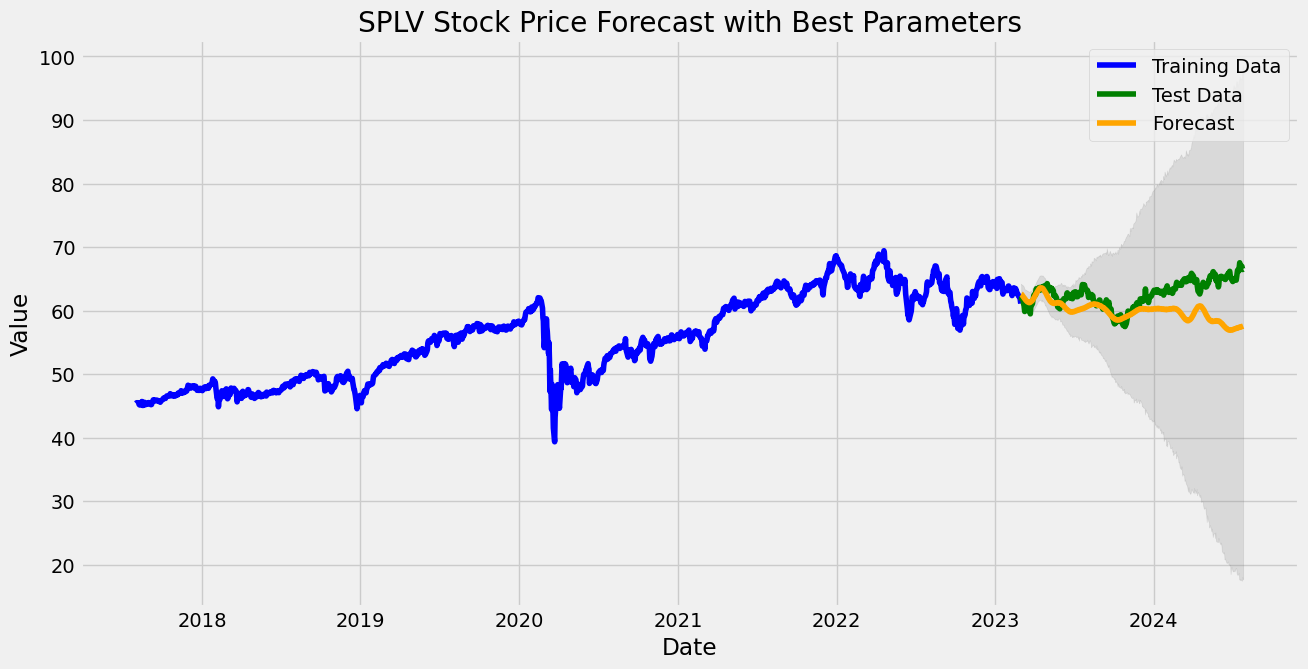

In [36]:
# Plot the results
fig = plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='green')

# Plot the forecasted data
plt.plot(matched_data ['ds'], matched_data ['yhat'], label='Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(matched_data ['ds'], matched_data ['yhat_lower'], matched_data ['yhat_upper'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('{} Stock Price Forecast with Best Parameters'.format(stock))
plt.legend()
#plt.ylim(0,80)

plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_y = test_data['y']  # Actual values
predicted_y = matched_data['yhat']  # Predicted values

mse = mean_squared_error(test_y, predicted_y)
mae = mean_absolute_error(test_y, predicted_y)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(test_y - predicted_y) / np.abs(test_y))

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

PROPHET_results = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Value': [mse, mae, rmse, mape]
})

MSE: 15.47107286799544
MAE: 2.9188565345374418
RMSE: 3.9333284719173203
MAPE: 0.0454764872132635


In [38]:
PROPHET_results

,Metric,Value
0,MSE,15.471073
1,MAE,2.918857
2,RMSE,3.933328
3,MAPE,0.045476


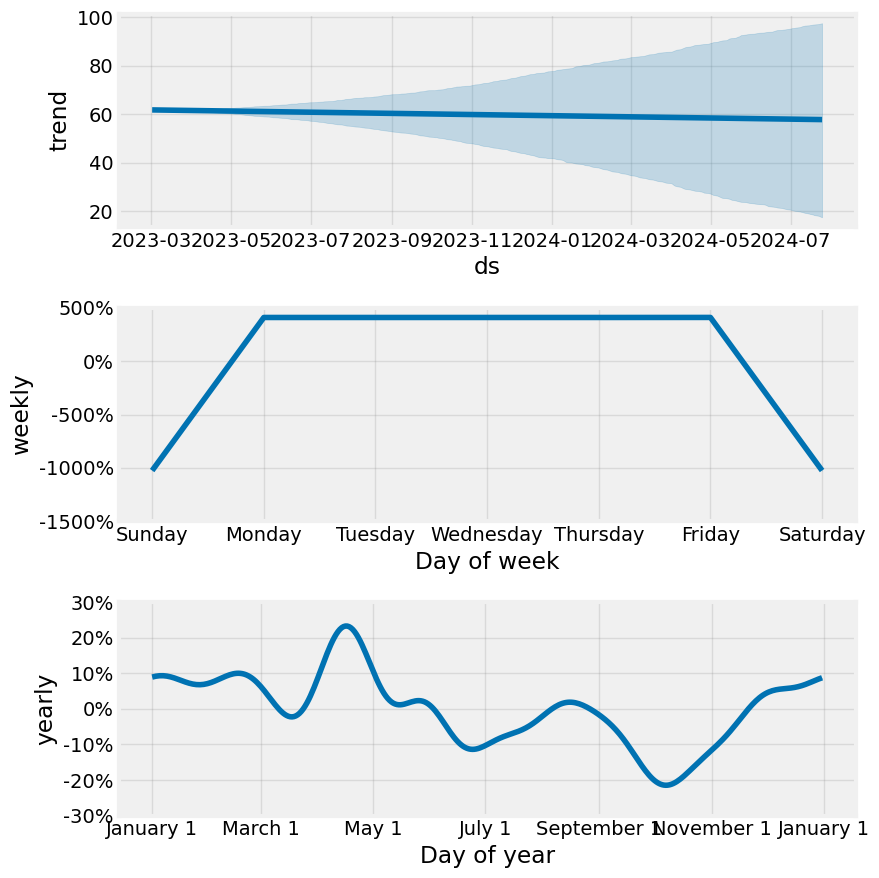

In [39]:
fig = model.plot_components(matched_data)

plt.show()

Predicting Future values

In [40]:
future = final_model.make_future_dataframe(periods= 800,freq='D') 

# Predict future values
forecast = final_model.predict(future)

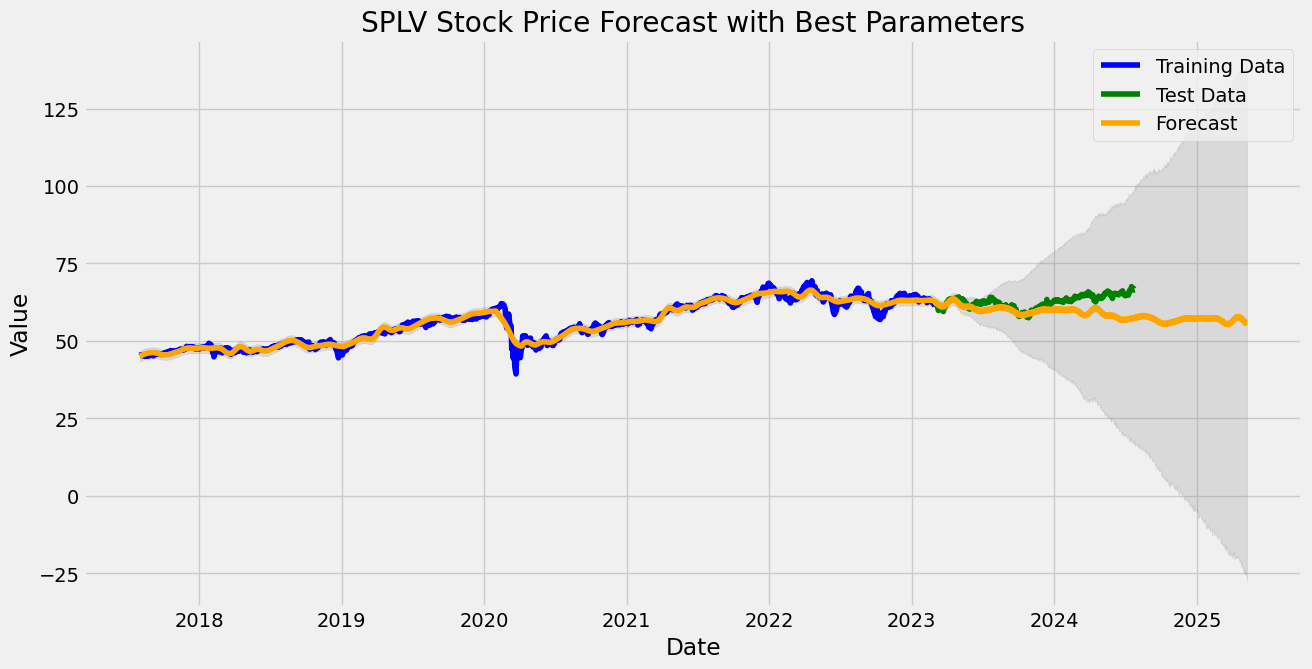

In [41]:
# Plot the results
fig = plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='green')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast ['yhat'], label='Forecast', color='orange')

# Plot the confidence intervals
plt.fill_between(forecast ['ds'], forecast ['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('{} Stock Price Forecast with Best Parameters'.format(stock))
plt.legend()
#plt.ylim(0,400)

plt.show()

In [42]:
PROPHET_results

,Metric,Value
0,MSE,15.471073
1,MAE,2.918857
2,RMSE,3.933328
3,MAPE,0.045476


## Comparative Analysis <a class="anchor" id="5"></a>

  Metric    Prophet     ARIMA
0    MSE  14.090119  4.287156
1    MAE   2.773540  1.550832
2   RMSE   3.753681  2.070545
3   MAPE   0.043234  0.024767


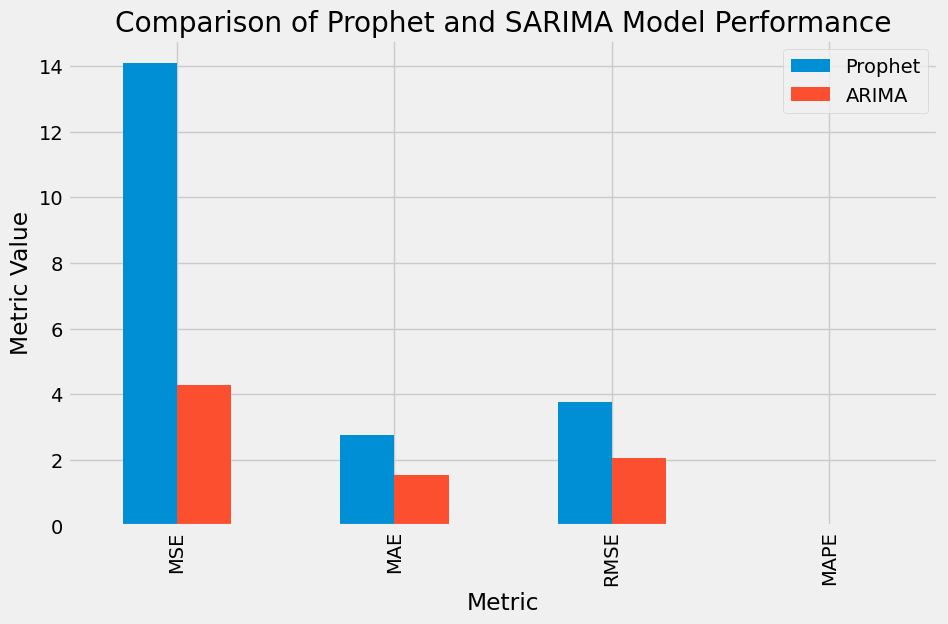

In [43]:

# Data
data = {
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'],
    'Prophet': [14.090119, 2.773540, 3.753681, 0.043234],
    'ARIMA': [4.287156021439776, 1.550832438078203, 2.070544861006343, 0.0247668892445323]
}

# Create DataFrame
overall_results = pd.DataFrame(data)

# Display DataFrame
print(overall_results)

# Plotting
overall_results.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Prophet and SARIMA Model Performance')
plt.ylabel('Metric Value')
plt.show()

SARIMA has a lower MSE, indicating it has better overall accuracy in capturing the variance in the data. <br>
SARIMA has a lower MAE, indicating it has better accuracy in terms of absolute differences between the predicted and actual values.<br>
SARIMA has a lower RMSE, indicating it has better accuracy and lower prediction error magnitude.<br>
SARIMA has a lower MAPE, indicating it has better accuracy in terms of percentage error. <br>



Based on the provided metrics, the SARIMA model outperforms the Prophet model across all evaluation metrics (MSE, MAE, RMSE, and MAPE). Therefore, SARIMA would be the preferred model for your time series forecasting task. <br>




In [44]:
overall_results

,Metric,Prophet,ARIMA
0,MSE,14.090119,4.287156
1,MAE,2.773540,1.550832
2,RMSE,3.753681,2.070545
3,MAPE,0.043234,0.024767
